In [1]:
import circle_bundles as cb

#For saving
folder_path = '/Users/bradturow/Desktop/Diagrams/Paper Diagrams/'

# Klein Bottle Model

In [2]:
#Generate a sampling of the Klein bottle model over RP1
from synthetic.nat_img_patches import sample_nat_img_kb, get_gradient_dirs

n_samples = 5000
n = 3

data, base_points = sample_nat_img_kb(n_samples, n = n)
grad_dirs = get_gradient_dirs(data)[0]
print(f'{n_samples} natural image patches generated.')

5000 natural image patches generated.


## Preliminary Analysis 

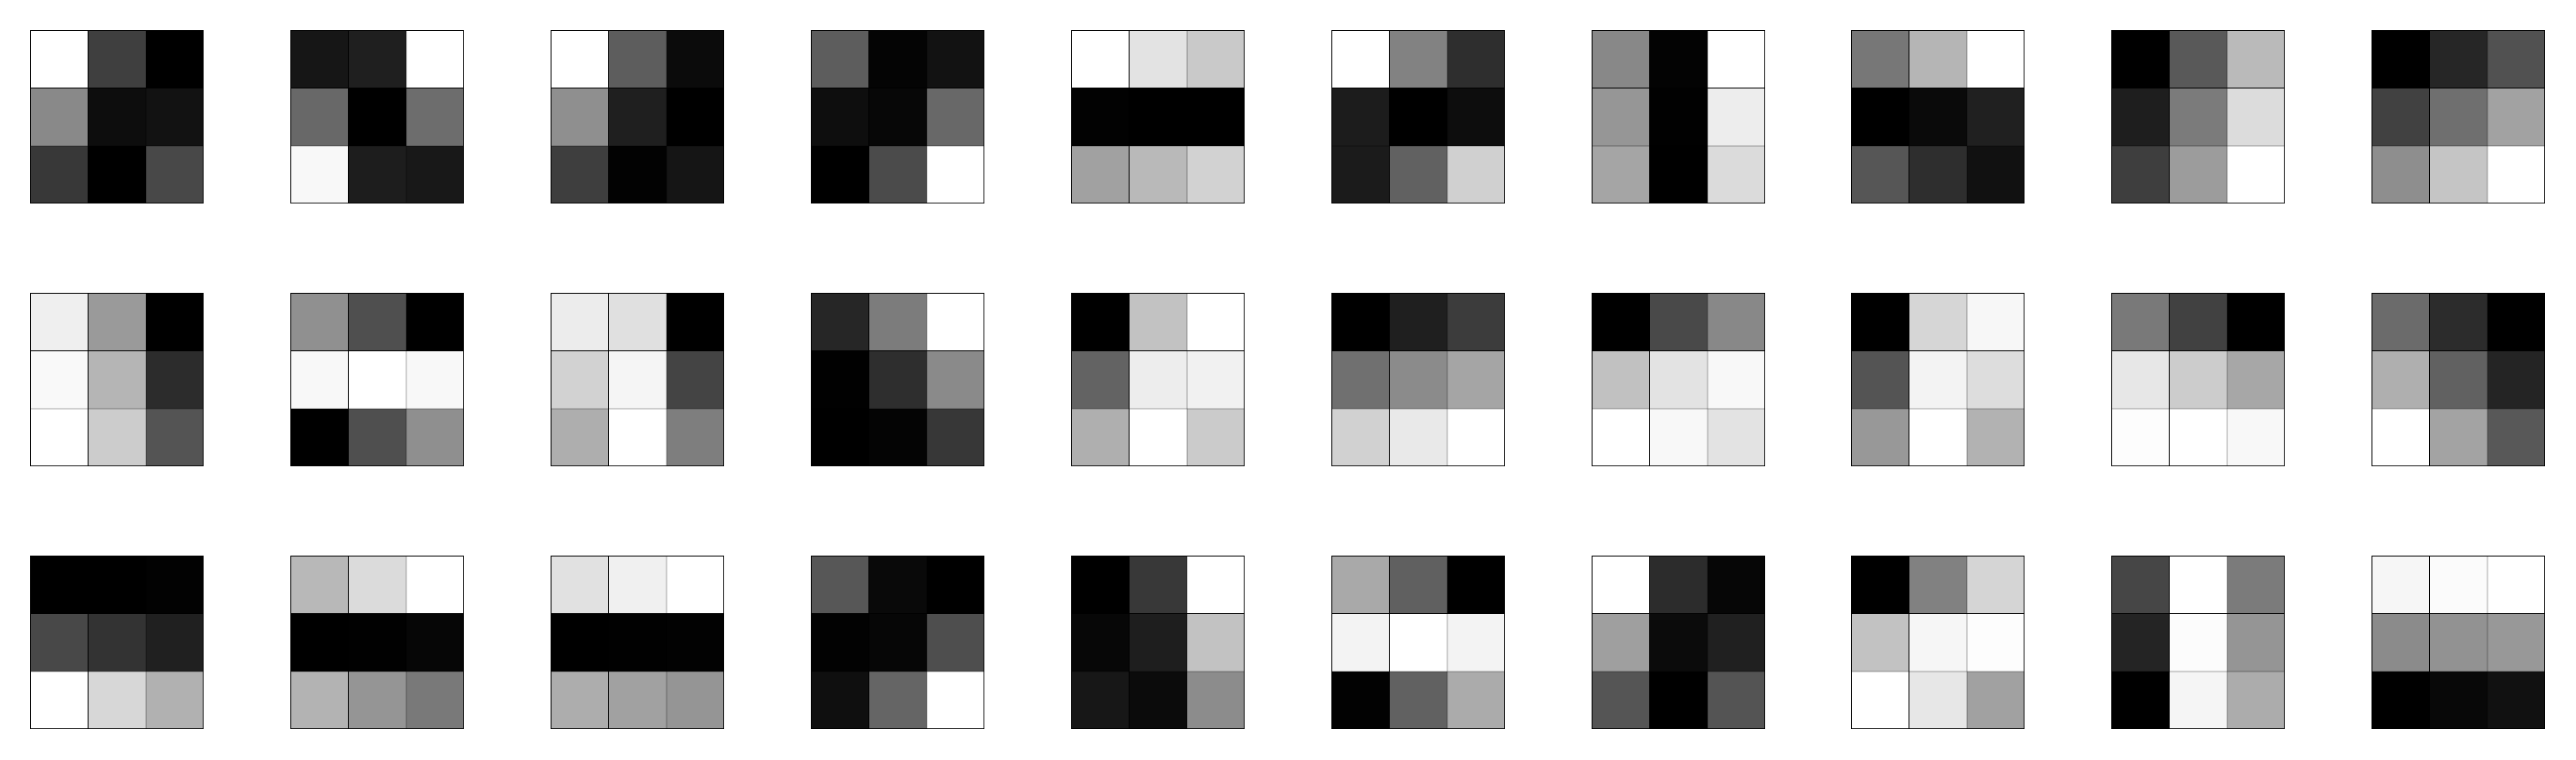

In [3]:
#View a sample of the data
import matplotlib.pyplot as plt
from optical_flow.patch_viz import make_patch_visualizer

patch_vis = make_patch_visualizer()
fig = cb.show_data_vis(data, patch_vis, sampling_method = None, max_samples = 30)
plt.show()

In [ ]:
#Show a PCA visualization of the dataset
cb.show_pca(data)

In [4]:
#Show an interactive visualization of the projection 
from circle_bundles.metrics import RP1UnitVectorMetric as rp1_metric

app = cb.show_bundle_vis(base_points = base_points, 
                         data  = data, 
                         base_metric = rp1_metric(), 
                         colors = grad_dirs) #Colored according to base projection
plt.show()

Bundle viewer running at: http://127.0.0.1:61223/


In [ ]:
#Run Ripser on a sample of the data

from ripser import ripser
from persim import plot_diagrams


# Run Ripser
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


## Bundle Analysis 

In [ ]:
#Construct a cover of the base space

n_landmarks = 12
lmk_angs = np.linspace(0, np.pi,n_landmarks, endpoint= False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.99

radius = overlap* np.pi/(2*n_landmarks)

cover = cb.MetricBallCover(base_points, landmarks, radius, metric = rp1_metric())
cover_data = cover.build()

#Show a summary of the cover
summ = cover.summarize(plot=True)
plt.show()

In [ ]:
#Construct local circular coordinates using Dreimac library
#and model transitions as O(2) matrices

from dreimac import CircularCoords

bundle = cb.build_bundle(
    data,
    cover,
    CircularCoords_cls=CircularCoords,
    show=True,
)


In [ ]:
#Show the correlations between local circular coordinates on overlaps
cb.attach_bundle_viz_methods()

fig = bundle.compare_trivs(ncols = 4)
plt.show()

In [ ]:
#Compute class persistence on the weights filtration of the nerve
pers = bundle.get_persistence(show = True)


In [ ]:
#Construct Stiefel frames
#and show mean squared error for PSC in different dimensions

tf = bundle.get_frame_dataset(
    reducer=None,
    max_frames = None,
    stage = 'post_projection',
    subcomplex = 'max_trivial')
Phi_true = tf.Y


D = Phi_true.shape[1]
dims = list(range(2, min(D, 60) + 1, 2)) 

dims_arr, psc_err = cb.reduction_curve_psc(
    Phi_true=Phi_true,
    U=cover.U,
    dims=dims,
    max_frames=2000,     
    rng_seed=0,
    psc_verbosity=0,
    use_manopt=False,    
    plot = True,
)


In [ ]:
#Compute a bundle map compatible with a subcomplex of the nerve

#Choose a dimensionality reducer (if any)
reduced_dim = 4
reducer = cb.FrameReducerConfig(method="psc", d=reduced_dim, max_frames=1000)

subcomplex = 'full'    # Choices are 'full', 'cocycle', 'max_trivial'
bm = bundle.get_bundle_map(show_summary = True, reducer = None, subcomplex = 'full')
F = bm.F


In [ ]:
app = cb.show_bundle_vis(base_points = base_points, 
                         data  = F, 
                         base_metric = rp1_metric(), 
                         colors = grad_dirs) #Colored according to base projection
plt.show()

In [ ]:
# Run Ripser on the Stiefel frame point cloud representation

dgms_2 = ripser(F, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(F, coeff=3, maxdim=2, n_perm=500)["dgms"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


In [ ]:
#Get a global coordinatization compatible with the maximal subcomplex of the nerve on which 
#the characteristic class representatives are coboundaries 

triv_result = bundle.get_global_trivialization()
print('Global coordinates computed.')

In [ ]:
#Show an interactive visualization of the bundle colored by fiber coordinate
fig = bundle.show_bundle(colors = triv_result.F)
plt.show()



In [ ]:
#Show a visualization of the nerve labeled with SW1

#Compute a potential for the restricted orientation class
subcomplex = bundle.get_max_trivial_subcomplex()
edges = subcomplex.kept_edges
Omega = bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = bundle.classes.omega_O1_used

fig = bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()

In [ ]:
#Show a recovered patch diagram
per_row = 5
per_col = 9
predom_dirs = np.arctan2(base_points[:,1], base_points[:,0]) % np.pi
coords = np.column_stack([predom_dirs.reshape(-1,1), triv_result.F.reshape(-1,1)])

fig = cb.lattice_vis(
    data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=15,
    thumb_px=350,   
    dpi=350         
)

plt.show()
